# Tuition Modeling
## Step 2: Enrollment Predictions

The purpose of this script is to take clean data from Step 1 and generate a predictive model. The (clean) data will be taken and first features will be engineered/generated. Then, gradient boosting will be used to create a predictive model of student enrollment.

### Goals

* Take clean data and generate features of interest
* Create ML models for predictions
* Export model and related data needed later

### Process

* A. Load data and modules
* B. Set option flags
* C. Create derived features (feature engineering part 1) 
* D. Dummify and generate combinatorial features (feature engineering part 2)
* E. Split into training and test sets and normalize
* F. Run classifiers
* G. Export results


### Resources

* http://blog.yhat.com/posts/logistic-regression-python-rodeo.html 
* http://machinelearningmastery.com/logistic-regression-tutorial-for-machine-learning/
* http://www.dataschool.io/logistic-regression-in-python-using-scikit-learn/
* https://www.r-bloggers.com/how-to-perform-a-logistic-regression-in-r/

## Part A: Load data and modules
### Part A1 - Load modules

In [1]:
# Load in software libraries
import os
import sys
import pandas as pd
import numpy as np
import pickle

# Get data-munging libraries
from sklearn import preprocessing
from sklearn.preprocessing import Binarizer, FunctionTransformer, PolynomialFeatures
from sklearn import decomposition

# Get ML libraries
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.kernel_approximation import Nystroem
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline, make_union
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

import statsmodels.api as sm
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.cross_validation import train_test_split

from imblearn.over_sampling import SMOTE 

# Get Viz libraries
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

C:\Python27\Lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Part A2 - Load data

In [2]:
df = pd.read_csv('../preprocessing/pugoDataClean.csv') #only data needed. Should be output from preprocessing script

In [3]:
#These are tuition amounts for each year, non-resident. 
#http://opb.washington.edu/sites/default/files/opb/Tuition/2016-17%20Tuition%20%26%20Fee%20History.pdf

df.loc[df.ApplYr == 2010, 'Tuition'] = 25329
df.loc[df.ApplYr == 2011, 'Tuition'] = 28058
df.loc[df.ApplYr == 2012, 'Tuition'] = 29938
df.loc[df.ApplYr == 2013, 'Tuition'] = 31971
df.loc[df.ApplYr == 2014, 'Tuition'] = 33513
df.loc[df.ApplYr == 2015, 'Tuition'] = 34143
df.loc[df.ApplYr == 2016, 'Tuition'] = 34791
df.loc[df.ApplYr == 2017, 'Tuition'] = 35538

In [4]:
df_backup = df.copy(deep=True)

### Part A3 - Sanity checks

In [5]:
# Look at the columns in the data
df.columns

Index([u'ApplYr', u'Enrolled', u'Admitted', u'PuGoOffer',
       u'HolisticAcademicScore', u'HolisticPQAScore',
       u'HolisticAdmissionScore', u'parent1_ed_level', u'parent2_ed_level',
       u'HighestParentalEducation',
       ...
       u'ed_3', u'ed_4', u'ed_5', u'ed_6', u'ed_1m', u'ed_2m', u'ed_3m',
       u'ed_4m', u'ed_5m', u'AcademicScore_imputed'],
      dtype='object', length=108)

In [6]:
#make sure all this is as expected
print len(df)

71699


In [7]:
print len(df[df.Admitted == 1])
print len(df[df.Enrolled == 1])

34874
5081


In [8]:
df.groupby('ApplYr').Enrolled.mean() #mean enrollment rates, regardless of admittance

ApplYr
2014    0.092415
2015    0.087651
2016    0.057361
2017    0.057714
Name: Enrolled, dtype: float64

In [9]:
df.HolisticAcademicScore.describe() #what we'll be sorting on later

count    71699.000000
mean        11.713469
std          3.487915
min          0.000000
25%         10.000000
50%         12.000000
75%         14.000000
max         18.000000
Name: HolisticAcademicScore, dtype: float64

In [10]:
df.PuGoOffer.describe() #previous offers made to students

count    71699.000000
mean      1609.607526
std       2631.377244
min          0.000000
25%          0.000000
50%          0.000000
75%       3250.000000
max       9000.000000
Name: PuGoOffer, dtype: float64

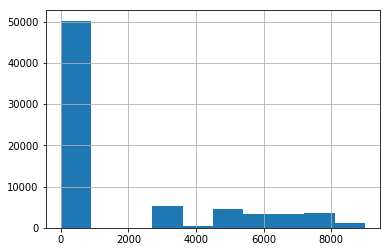

In [11]:
df.PuGoOffer.hist()

In [12]:
df.PuGoOffer.value_counts()

0       50233
3250     4781
4500     4175
5500     3384
6500     2641
7500     2630
8500     1052
8000      843
7000      619
4000      472
3000      429
5000      394
9000       46
Name: PuGoOffer, dtype: int64

## Part B - Set option flags

In [13]:
df['ApplYr'].value_counts()

2017    21676
2016    20397
2015    16349
2014    13277
Name: ApplYr, dtype: int64

### Part B1 - Set flags

Set the year
Visualize or not
Normalize or not
Simple or detailed accuracy metrics

In [14]:
only_use_admitted = False #only use admitted students in the predictions
exclude_eps = True #exclude EPS data (should almost always be True)

use_all_years = False #include all years in the analysis
year = 2017 #if the above is not true, which years to use
use_most_recent = True #instead use data from 2014-2017

check_only_last_year = 0 #used in fine-tuning cutoff for predictions. If desired, should be a single integer value for a year

use_pugo_amounts = True #include PuGo amounts in predictions (should almost always be True)

normalize_metrics = True #whether or not to scale values (should almost always be True)

drop_all_nulls = True #remove any column(s) with a null value

stratify_split = False #stratify the train-test split by class (i.e. enrolled or not)

save_results = True #save final outputs

### Part B2 - Further data cleaning

In [15]:
if not use_all_years: #use years of interest based on the above option flags
    if use_most_recent:
        df = df[df['ApplYr'].isin([2017, 2016, 2015, 2014])]
    else:
        df = df.loc[df['ApplYr'] == year]

df = df.reset_index(drop=True) 

df.columns[df.isnull().sum() != 0] #check that there are no columns with nulls

Index([], dtype='object')

In [16]:
if only_use_admitted: #only if using admits only
    df = df[df.Admitted == 1]

## Part C - Create derived features

### Part C1 - Tuition after grants

In [17]:
#these features are key. Essentially, we only want a single variable (tuition after grants) 
#that accounts for scholarship funds and changes thereto

if use_pugo_amounts:
    df['tuition_after_grants'] = df['Tuition'] - df['PuGoOffer'] - df['GrantSchol']
else:
    df['tuition_after_grants'] = df['Tuition'] - df['GrantSchol']

df.loc[df.tuition_after_grants < 0, 'tuition_after_grants'] = 0

In [18]:
df.tuition_after_grants.describe()

count    71699.000000
mean     32663.400033
std       3297.708428
min       4912.000000
25%      31038.000000
50%      34143.000000
75%      34791.000000
max      35538.000000
Name: tuition_after_grants, dtype: float64

### Part C2 - Add more features

Essentially adding more features and swapping things around. Previous versions of the code joined some of the below-created features to retention data but that has since been removed.

In [19]:
df['AcademicRankPctYr'] = df.groupby(['ApplYr'])['AcademicRank'].rank(pct = True, ascending = True)

In [20]:
df['LowerHighSchoolGPA'] = 0
df.loc[df.HS_GPA > 3.0, 'LowerHighSchoolGPA'] = 3
df.loc[df.HS_GPA > 3.4, 'LowerHighSchoolGPA'] = 3.4
df.loc[df.HS_GPA > 3.6, 'LowerHighSchoolGPA'] = 3.6
df.loc[df.HS_GPA > 3.8, 'LowerHighSchoolGPA'] = 3.8

In [21]:
df['UpperHighSchoolGPA'] = 3
df.loc[df.HS_GPA > 3, 'UpperHighSchoolGPA'] = 3.4
df.loc[df.HS_GPA > 3.4, 'UpperHighSchoolGPA'] = 3.6
df.loc[df.HS_GPA > 3.6, 'UpperHighSchoolGPA'] = 3.8
df.loc[df.HS_GPA > 3.8, 'UpperHighSchoolGPA'] = 4.0

In [22]:
data_all = df[df.TestScore > 0] #remove students with null entries here

In [23]:
pugoTuitionAndGrantData = data_all[['PuGoOffer', 'GrantSchol', 'Tuition', 'ApplYr', 'Admitted']]
data_all.drop('ApplYr', axis=1, inplace=True)
data_all.drop('GrantSchol', axis=1, inplace=True)
data_all.drop('PuGoOffer', axis=1, inplace=True)
data_all.drop('Tuition', axis=1, inplace=True)

print 'There are ' + str(data_all.HS_GPA.count()) + ' rows'

There are 71699 rows


In [24]:
if exclude_eps:
    epsCols = ['UWAttraction_TotalCount', u'UWAttraction_TotalPct',
       u'UWAttraction_ProdPct', u'UWLocationAttraction_TotalCount',
       u'UWLocationAttraction_TotalPct', u'UWEdGoals_TotalCount',
       u'UWEdGoals_TotalPct', u'UWEdGoals_ProdPct']
    data_all = data_all.drop(epsCols, axis = 1, errors = 'ignore')

## Part D - Dummify and generate combinatorial features

### Part D1 - Create dummies

In [25]:
isEnrolledOrMatriculated = data_all.Enrolled.copy()

In [26]:
#removal of null values

if drop_all_nulls:
    cols = data_all.columns[data_all.isnull().any()]
    data_all = data_all.loc[~data_all[cols].isnull().any(axis = 1)]
    isEnrolledOrMatriculated = isEnrolledOrMatriculated.loc[data_all.index]

In [27]:
len(data_all)

71699

### Part D2 - Predict admissions

This was added because admissions will not have a complete list of who is and isn't admitted at the time PuGo offers are made. Though, ultimately, previous years' data was used in 2018, these predictions of admissions play a large part in downstream predictions of enrollment

In [28]:
if not only_use_admitted:
    # these predictions are made using a simple logistic regression
    parameters = {'C': [0.1, 1, 2.5, 5, 7.5, 10, 12.5, 15, 100]} #these are regularization parameters for predictions
    model = LogisticRegression()
    #train-test split
    x_train, x_test, y_train, y_test = train_test_split(data_all.drop(['Enrolled', 'Admitted'], axis = 1), data_all['Admitted'], train_size = 0.8, random_state = 42, stratify = data_all['Admitted'])

    #create a scaler to normalize data
    scalerAdmit = preprocessing.RobustScaler().fit(x_train)
    x_train = pd.DataFrame(scalerAdmit.transform(x_train))

    #search across the regularization parameters for the best one
    grid = GridSearchCV(model, parameters, scoring = 'roc_auc', cv = 5, verbose = 1)
    grid.fit(x_train, y_train)

    #prediction model for admittance
    clfAdmit = LogisticRegression(C = grid.best_params_['C'])
    clfAdmit.fit(x_train, y_train)

    #calculated values
    probs = clfAdmit.predict_proba(scalerAdmit.transform(data_all.drop(['Enrolled', 'Admitted'], axis = 1)))
    predicts = clfAdmit.predict(scalerAdmit.transform(data_all.drop(['Enrolled', 'Admitted'], axis = 1)))

    #add as features for downstream predictions
    data_all['isAdmittedProbs'] = pd.Series(probs[:,1], index = data_all.index)
    data_all['isAdmittedPredict'] = pd.Series(predicts, index = data_all.index)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  1.1min finished


In [29]:
check = scalerAdmit.transform(data_all.drop(['Enrolled', 'Admitted', 'isAdmittedProbs', 'isAdmittedPredict'], axis = 1))
clfAdmit.score(check, data_all['Admitted']) #check accuracy. (should be >96%)

0.9604736467733163

In [30]:
grid.best_params_ #best regularization parameter

{'C': 7.5}

In [31]:
print data_all.isAdmittedPredict.sum()
print data_all.Admitted.sum()
print data_all.isAdmittedPredict.sum() * 1.0 / data_all.Admitted.sum() #ratio of predicted admittees to actual admittees

34266
34874
0.9825658083385903


In [32]:
coefs = pd.Series(clfAdmit.coef_[0], index = data_all.drop(['Enrolled', 'Admitted', 'isAdmittedProbs', 'isAdmittedPredict'], axis = 1, errors = 'ignore').columns)
coefs.sort_values() #look at the regression coefficients for the admittance predictions

tuition_after_grants           -2.133650
FAFSAFiledOnTime               -1.340222
HolisticAcademicScore          -1.182343
Unfunded40Kplus_Fin6           -1.094563
hs_code_50718.0                -0.762006
TR_GPA_exists                  -0.738232
Unfunded40K_Fin5               -0.718068
hs_code_53218.0                -0.600638
FiledFAFSA                     -0.559322
Unfunded30K_Fin4               -0.554516
Unfunded0K_Fin2                -0.530250
HS_Yrs_Math                    -0.525231
Dependency                     -0.438961
hs_code_53343.0                -0.400025
hs_state_OR                    -0.392777
hs_state_NV                    -0.346755
entry_class_1                  -0.316167
hs_state_AZ                    -0.303998
Other_Budget                   -0.277231
over_20                        -0.264172
hs_code_53463.0                -0.251442
AcademicRank                   -0.202974
ed_0                           -0.193582
AcademicScore                  -0.180430
hs_state_IL     

In [33]:
data_all = data_all.drop(['Admitted'], axis = 1) #this is dropped because it won't be known for the current cycle

### Part D3 - Split off matrices for predictions

In [34]:
y = data_all.Enrolled #target for predictions (just predicting enrollment here)
x = data_all.copy() #everything else

x.drop('Enrolled', axis=1, inplace=True)

### Part D4 - Create additional features

References from Dev Nambi:
* Very useful - http://stackoverflow.com/questions/33257199/how-to-generate-many-interaction-terms-in-pandas
* Reference - http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html



* Complicated - http://www.dummies.com/programming/big-data/data-science/data-science-how-to-create-interactions-between-variables-with-python/
* http://patsy.readthedocs.io/en/latest/
* http://stats.idre.ucla.edu/stata/seminars/deciphering-interactions-in-logistic-regression/
* https://www.datarobot.com/blog/multiple-regression-using-statsmodels/
* http://stackoverflow.com/questions/33050104/difference-between-the-interaction-and-term-for-formulas-in-statsmodels-ols

Note: part D4 was not found to be useful in predictions. Thus, everything is set to False here. - Lavi

In [35]:
squaredFeatures = False #if true, will square every feature and include
logFeatures = False #if true, will take log of every feature and include
expFeatures = False #if true, will exponentiate every feature and include
interactionFeatures = False #if true, will generate interaction terms and include

In [36]:
hold = x.copy()
hold = hold.drop(['tuition_after_grants'], axis = 1) #we only want a single feature associated with this!!
if squaredFeatures:
    interactionFeatures = False
    poly = PolynomialFeatures(2, interaction_only = False, include_bias = False)
    temp = poly.fit_transform(hold)
    x = pd.DataFrame(temp, columns = poly.get_feature_names(x.columns), index = x.index)
if logFeatures:
    tempDF = hold.copy()
    tempDF[tempDF == 0] = 0.01
    temp = np.log(abs(tempDF))
    temp.columns = ['log-' + each for each in hold.columns]
    x = x.join(temp)
if expFeatures:
    tempDF = hold.copy()
    temp = np.exp(tempDF)
    temp[temp > 10000] = 10000
    temp.columns = ['exp-' + each for each in hold.columns]
    x = x.join(temp)
if interactionFeatures:
    scoreFeatures = False
    poly = PolynomialFeatures(2, interaction_only = True, include_bias = False)
    temp = poly.fit_transform(hold)
    x = pd.DataFrame(temp, columns = poly.get_feature_names(x.columns), index = x.index)    

In [37]:
#remove columns with all 0s or all 1s, because constants are useless
x = x.drop(x.columns[(x == 0).all()], axis = 1)
x = x.drop(x.columns[(x == 1).all()], axis = 1)

In [38]:
x.shape #final shape - be sure this is what we expect!!

(71699, 107)

In [39]:
x.tail() #sanity check

HolisticAcademicScore  HolisticPQAScore  HolisticAdmissionScore  \
71694                      8                 8                     8.0   
71695                     10                 8                    10.0   
71696                     11                 5                    11.0   
71697                     10                 8                    10.0   
71698                     10                 4                    10.0   

       parent1_ed_level  parent2_ed_level  HighestParentalEducation  \
71694               6.0               6.0                       6.0   
71695               3.0               2.0                       3.0   
71696               6.0               5.0                       6.0   
71697               2.0               2.0                       2.0   
71698               5.0               3.0                       5.0   

       TestScore  AcademicScore  AcademicRank  HS_AI        ...          \
71694     1380.0       0.752000          1023   43.0        ...           
71695      950.0       0.922063          3578   68.0        ...           
71696     1280.0       0.842500          2292   59.0        ...           
71697     1190.0       0.736313           869   35.0        ...           
71698      858.0       0.682125           444   70.0        ...           

       ed_3m  ed_4m  ed_5m  AcademicScore_imputed  tuition_after_grants  \
71694      1      1      1               0.752000                 35538   
71695      1      0      0               0.922063                 35538   
71696      1      1      1               0.842500                 35538   
71697      0      0      0               0.736313                 35538   
71698      1      1      1               0.762563                 35538   

       AcademicRankPctYr  LowerHighSchoolGPA  UpperHighSchoolGPA  \
71694           0.092176                 0.0                 3.0   
71695           0.653188                 3.8                 4.0   
71696           0.308406                 3.0                 3.4   
71697           0.073468                 0.0                 3.0   
71698           0.030195                 3.0                 3.4   

       isAdmittedProbs  isAdmittedPredict  
71694         0.000526                  0  
71695         0.001214                  0  
71696         0.025147                  0  
71697         0.000031                  0  
71698         0.005226                  0  

[5 rows x 107 columns]

## Part E - Split into training and test sets and normalize

1. Come up with interaction terms
2. Use a 80-20 split

### Part E1 - Split in a 80-20 split

In [40]:
len(x)

71699

In [41]:
y.value_counts()

0    66618
1     5081
Name: Enrolled, dtype: int64

In [42]:
# create training and testing split for predictions
if stratify_split == True:
    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.8, random_state = 42, stratify=y)
else:
    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.8, random_state = 42)

print 'x_train has ' + str(len(x_train)) + ' observations'
print 'y_train has ' + str(len(y_train)) + ' observations'
print 'x_test has ' + str(len(x_test)) + ' observations'
print 'y_test has ' + str(len(y_test)) + ' observations'


x_train has 57359 observations
y_train has 57359 observations
x_test has 14340 observations
y_test has 14340 observations


In [43]:
#Note - this was moved here from Dev's code. Scaling should be done after train/test split and using train data as a basis! - Lavi

if normalize_metrics:
    print 'Normalized'
    scaler = preprocessing.RobustScaler().fit(x_train) #Lavi - swapped to robust scaler
    x_train = pd.DataFrame(scaler.transform(x_train), index = x_train.index, columns = x_train.columns)
    x_test = pd.DataFrame(scaler.transform(x_test), index = x_test.index, columns = x_test.columns)

Normalized


### Part E2 - Use SMOTE

Note: Part E2 was not found to be useful in predictions - Lavi

More on SMOTE, if it is of interest: https://arxiv.org/abs/1106.1813

In [44]:
smote = False

if smote:
    sm = SMOTE(random_state = 11)
    colX = x_train.columns
    indX = x_train.index
    colY = y_train.name
    indY = y_train.index
    x_train, y_train = sm.fit_sample(x_train, y_train)
    x_train = pd.DataFrame(x_train, columns = colX)
    y_train = pd.Series(y_train, name = colY)

In [45]:
y_train.value_counts()

0    53310
1     4049
Name: Enrolled, dtype: int64

In [46]:
#export data and use in cross validation scripts (optional)
x_train.join(y_train).to_csv('train.csv')

## Part F - Run gradient boosting classifier

* http://statsmodels.sourceforge.net/devel/example_formulas.html
* http://statsmodels.sourceforge.net/stable/generated/statsmodels.discrete.discrete_model.Logit.html#statsmodels.discrete.discrete_model.Logit


In [47]:
params = {'learning_rate': 0.05, 'min_samples_leaf': 0.06, 'n_estimators': 2000, 
 'min_samples_split': 0.16, 'max_features': 0.38, 'max_depth': 6}
clfXgb = GradientBoostingClassifier(**params) #options/params
clfXgb.fit(x_train, y_train) #fit model
probsXgbTrain = clfXgb.predict_proba(x_train)[:, 1]
probsXgbTest = clfXgb.predict_proba(x_test)[:, 1]

In [48]:
params = {'max_features': 0.37, 'n_estimators': 860, 'max_depth': 12, 'min_samples_leaf': 11}
clfRf = RandomForestClassifier(**params)
clfRf.fit(x_train, y_train)
probsRfTrain = clfRf.predict_proba(x_train)[:, 1]
probsRfTest = clfRf.predict_proba(x_test)[:, 1]

In [49]:
params = {'hidden_layer_sizes': (40, 35, 35), 'alpha' : 0.008, 
          'activation': 'logistic', 'max_iter': 10000}                     
clfNn = MLPClassifier(**params)
clfNn.fit(x_train, y_train)
probsNnTrain = clfNn.predict_proba(x_train)[:, 1]
probsNnTest = clfNn.predict_proba(x_test)[:, 1]

## Part G - Evaluate the results for accuracy

### Part G1 - Look at the accuracy scores lift

In [50]:
# In general, it is possible to get perfect accuracy with GBM without too much overfitting. Next cell is more important
print 'Baseline training accuracy is ' + str(1.0-y_train.mean()) + '\n\n'

print 'XGB score: ' + str(clfXgb.score(x_train, y_train))
print 'XGB improvement: ' + str((clfXgb.score(x_train, y_train)) - (1.0-y_train.mean()))
print 'XGB percent improvement: ' + str(((clfXgb.score(x_train, y_train)) - (1.0-y_train.mean())) / y_train.mean())
print '\n\n'
print 'RF score: ' + str(clfRf.score(x_train, y_train))
print 'RF improvement: ' + str((clfRf.score(x_train, y_train)) - (1.0-y_train.mean()))
print 'RF percent improvement: ' + str(((clfRf.score(x_train, y_train)) - (1.0-y_train.mean())) / y_train.mean())
print '\n\n'
print 'NN score: ' + str(clfNn.score(x_train, y_train))
print 'NN improvement: ' + str((clfNn.score(x_train, y_train)) - (1.0-y_train.mean()))
print 'NN percent improvement: ' + str(((clfNn.score(x_train, y_train)) - (1.0-y_train.mean())) / y_train.mean())

Baseline training accuracy is 0.9294095085339702


XGB score: 0.9351976150211824
XGB improvement: 0.005788106487212175
XGB percent improvement: 0.0819955544578916



RF score: 0.9331926986174793
RF improvement: 0.003783190083509136
RF percent improvement: 0.053593479871573355



NN score: 0.9324953363901044
NN improvement: 0.0030858278561342045
NN percent improvement: 0.043714497406767555


In [51]:
# Been able to get test accuracy around 92-94%
print 'Baseline test accuracy is ' + str(1.0-y_test.mean()) + '\n\n'

print 'XGB score: ' + str(clfXgb.score(x_test, y_test))
print 'XGB improvement: ' + str((clfXgb.score(x_test, y_test)) - (1.0-y_test.mean()))
print 'XGB percent improvement: ' + str(((clfXgb.score(x_test, y_test)) - (1.0-y_test.mean())) / y_test.mean())
print '\n\n'
print 'RF score: ' + str(clfRf.score(x_test, y_test))
print 'RF improvement: ' + str((clfRf.score(x_test, y_test)) - (1.0-y_test.mean()))
print 'RF percent improvement: ' + str(((clfRf.score(x_test, y_test)) - (1.0-y_test.mean())) / y_test.mean())
print '\n\n'
print 'NN score: ' + str(clfNn.score(x_test, y_test))
print 'NN improvement: ' + str((clfNn.score(x_test, y_test)) - (1.0-y_test.mean()))
print 'NN percent improvement: ' + str(((clfNn.score(x_test, y_test)) - (1.0-y_test.mean())) / y_test.mean())

Baseline test accuracy is 0.9280334728033472


XGB score: 0.9313110181311018
XGB improvement: 0.003277545327754594
XGB percent improvement: 0.04554263565891558



RF score: 0.9306136680613668
RF improvement: 0.0025801952580195575
RF percent improvement: 0.03585271317829501



NN score: 0.9306136680613668
NN improvement: 0.0025801952580195575
NN percent improvement: 0.03585271317829501


### Part G2 - Look at the ROC/AUC scores

For more, see: http://gim.unmc.edu/dxtests/roc3.htm

In [52]:
# Not a surprise if perfect
print 'XGB train AUC: ' + str(metrics.roc_auc_score(y_train, probsXgbTrain))
print 'RF train AUC: ' + str(metrics.roc_auc_score(y_train, probsRfTrain))
print 'NN train AUC: ' + str(metrics.roc_auc_score(y_train, probsNnTrain))

XGB train AUC: 0.8975925655421888
RF train AUC: 0.9304478541542711
NN train AUC: 0.8599965003829704


In [53]:
# High has been about 0.85
print 'XGB test AUC: ' + str(metrics.roc_auc_score(y_test, probsXgbTest))
print 'RF test AUC: ' + str(metrics.roc_auc_score(y_test, probsRfTest))
print 'NN test AUC: ' + str(metrics.roc_auc_score(y_test, probsNnTest))

XGB test AUC: 0.8451817901687626
RF test AUC: 0.8483005064273283
NN test AUC: 0.846079134658176


### Part G3 - Find the best thresholds, F-Score optimize

In [54]:
x_train.columns

Index([u'HolisticAcademicScore', u'HolisticPQAScore',
       u'HolisticAdmissionScore', u'parent1_ed_level', u'parent2_ed_level',
       u'HighestParentalEducation', u'TestScore', u'AcademicScore',
       u'AcademicRank', u'HS_AI',
       ...
       u'ed_3m', u'ed_4m', u'ed_5m', u'AcademicScore_imputed',
       u'tuition_after_grants', u'AcademicRankPctYr', u'LowerHighSchoolGPA',
       u'UpperHighSchoolGPA', u'isAdmittedProbs', u'isAdmittedPredict'],
      dtype='object', length=107)

In [55]:
def change_cutpoint(new_threshold, probs):
    array_to_return = np.zeros(len(probs))
    for index, value in enumerate(probs):
        if value >= new_threshold:
            array_to_return[index] = 1
    return array_to_return

In [56]:
def find_cutpoint(probs, enrolled):
    best = 0
    for number in np.arange(0, 1000): #increment by 0.01
        cutoff = number / 1000.0
        new_predictions = change_cutpoint(cutoff, probs) #generate predictions based on this
        students = len(new_predictions[new_predictions >= cutoff]) #number of predicted enrollees
        if students <= enrolled: #if predicted is greater than actual
            best = cutoff
            break
    return best

In [57]:
enrolled = y_test.sum()
enrolled

1032

In [58]:
bestXgb = find_cutpoint(probsXgbTest, enrolled)
bestRf = find_cutpoint(probsRfTest, enrolled)
bestNn = find_cutpoint(probsNnTest, enrolled)

In [59]:
print bestXgb
print bestRf
print bestNn

0.226
0.191
0.199


In [60]:
#adjusted yield should be much closer to actual
print 'Total adjusted yield (Xgb) is: ' + str((clfXgb.predict_proba(x_train.append(x_test))[:,1] > bestXgb).sum()) + ' students'
print 'Total adjusted yield (Rf) is: ' + str((clfRf.predict_proba(x_train.append(x_test))[:,1] > bestRf).sum()) + ' students'
print 'Total adjusted yield (Nn) is: ' + str((clfNn.predict_proba(x_train.append(x_test))[:,1] > bestNn).sum()) + ' students'

print 'Actual yield is: ' + str(isEnrolledOrMatriculated.sum()) + ' students'

Total adjusted yield (Xgb) is: 5029 students
Total adjusted yield (Rf) is: 5063 students
Total adjusted yield (Nn) is: 5025 students
Actual yield is: 5081 students


## Part H - Export results

* Use pickle, https://docs.python.org/2/library/pickle.html 

In [61]:
if save_results: #save prediction model
    output_name = 'forOpt/tuition/tuitionXgb_model.pkl'
    with open(output_name, 'wb') as output:
        pickle.dump(clfXgb, output, pickle.HIGHEST_PROTOCOL)
    output_name = 'forOpt/tuition/tuitionRf_model.pkl'
    with open(output_name, 'wb') as output:
        pickle.dump(clfRf, output, pickle.HIGHEST_PROTOCOL)
    output_name = 'forOpt/tuition/tuitionNn_model.pkl'
    with open(output_name, 'wb') as output:
        pickle.dump(clfNn, output, pickle.HIGHEST_PROTOCOL)
    print 'Saved model'

Saved model


In [62]:
if save_results: #save values that are later used in addition to modeling
    pugoTuitionAndGrantData.to_csv('forOpt/tuition/pugoTuitionAndGrants.csv', index=False)
    print 'Saved pugo and grant amounts'

Saved pugo and grant amounts


In [63]:
if save_results: #save data
    x.join(y, rsuffix = '_r').to_csv('forOpt/tuition/data_all.csv', index=False)
    print 'Saved transformed data set'

Saved transformed data set


In [64]:
if save_results: #save scaler (to use if/when re-scaling)
    scaler_file = 'forOpt/tuition/scaler.pkl'
    with open(scaler_file, 'wb') as output:
        pickle.dump(scaler, output, pickle.HIGHEST_PROTOCOL)
    print 'Saved scaler'

Saved scaler


In [65]:
if save_results: #save column names
    output_name = 'forOpt/tuition/columns.pkl'
    with open(output_name, 'wb') as output:
        pickle.dump(x.columns, output, pickle.HIGHEST_PROTOCOL)
    print 'Saved columns'

Saved columns


In [66]:
if save_results: #save best cutoff value
    output_name = 'forOpt/tuition/bestXgb_cutoff.pkl'
    with open(output_name, 'wb') as output:
        pickle.dump(bestXgb, output, pickle.HIGHEST_PROTOCOL)
    output_name = 'forOpt/tuition/bestRf_cutoff.pkl'
    with open(output_name, 'wb') as output:
        pickle.dump(bestRf, output, pickle.HIGHEST_PROTOCOL)
    output_name = 'forOpt/tuition/bestNn_cutoff.pkl'
    with open(output_name, 'wb') as output:
        pickle.dump(bestNn, output, pickle.HIGHEST_PROTOCOL)
    print 'Saved cutoff'

Saved cutoff
